Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore, shapiro
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import chi2
from sklearn.preprocessing import KBinsDiscretizer
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix


Load the datasets

In [3]:
df = pd.read_csv(r"C:\Users\asus\Desktop\2021_Green_Taxi_Trip_Data.csv")
boroughs = pd.read_csv(r"C:\Users\asus\Desktop\Boroughs (1).csv")

C:\Users\asus\AppData\Local\Temp\ipykernel_6216\3809546871.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\asus\Desktop\2021_Green_Taxi_Trip_Data.csv")


Delete unnecessary columns

In [5]:
deleted_columns = ['RatecodeID', 'store_and_fwd_flag', 'improvement_surcharge', 'ehail_fee',
                   'mta_tax', 'extra', 'fare_amount', 'congestion_surcharge']

data = df.drop(deleted_columns, axis=1)

 Handling noisy and anomaly data

In [7]:
data = data[data["total_amount"] > 0]
data = data[data["tip_amount"] >= 0]
data = data[data["trip_distance"] > 0]

Filling Trip_Payment Null values for tipped trips

In [9]:
data.loc[data['tip_amount'] > 0, 'payment_type'] = 1

data.loc[data['passenger_count'] > 4, 'payment_type'] = 6
data['dispatch'] = data['passenger_count'].apply(lambda x: 1 if x > 4 else 0)

data = data.dropna(subset=['VendorID'])

Convert pickup and dropoff datetime to datetime format

In [11]:
data['lpep_pickup_datetime'] = pd.to_datetime(data['lpep_pickup_datetime'])
data['lpep_dropoff_datetime'] = pd.to_datetime(data['lpep_dropoff_datetime'])


C:\Users\asus\AppData\Local\Temp\ipykernel_6216\1935817582.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['lpep_pickup_datetime'] = pd.to_datetime(data['lpep_pickup_datetime'])
C:\Users\asus\AppData\Local\Temp\ipykernel_6216\1935817582.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['lpep_dropoff_datetime'] = pd.to_datetime(data['lpep_dropoff_datetime'])


Considering only 2021 year

In [13]:
data = data[data['lpep_pickup_datetime'].dt.year == 2021]
data = data[data['lpep_dropoff_datetime'].dt.year == 2021]

Remove exactly repeted data (if any exists)

In [15]:
data = data.drop_duplicates()

Handling missing values

In [17]:
# Calculating the missing percentage of the columns
missing_percentage = data.isnull().sum() / len(data) * 100
print(missing_percentage)

VendorID                  0.000000
lpep_pickup_datetime      0.000000
lpep_dropoff_datetime     0.000000
PULocationID              0.000000
DOLocationID              0.000000
passenger_count          20.591937
trip_distance             0.000000
tip_amount                0.000000
tolls_amount              0.000000
total_amount              0.000000
payment_type             16.900852
trip_type                20.591937
dispatch                  0.000000
dtype: float64


Convert datetime columns to numeric (timestamps)

In [19]:
data['lpep_pickup_datetime_copy'] = data['lpep_pickup_datetime'][:]
data['lpep_dropoff_datetime_copy'] = data['lpep_dropoff_datetime'][:] # so that its type won't be changed and can be used later.

for col in ['lpep_pickup_datetime', 'lpep_dropoff_datetime']:
    data[col] = pd.to_datetime(data[col], errors='coerce')  # Convert to datetime

Create trip_duration feature (in seconds)

In [21]:
data['trip_duration'] = (data['lpep_dropoff_datetime'] - data['lpep_pickup_datetime']).dt.total_seconds()

Convert datetime columns to timestamps for modeling

In [23]:
for col in ['lpep_pickup_datetime', 'lpep_dropoff_datetime']:
    data[col] = data[col].astype('int64') // 1e9  # Convert to seconds since epoch

Impute function

In [25]:
def impute_random_forest(data, target_col, exclude_cols, is_categorical=False):

    predictors = [col for col in data.columns if col not in exclude_cols]

    # Separate rows with and without missing values
    train_data = data[data[target_col].notna()]
    predict_data = data[data[target_col].isna()]

    X_train = train_data[predictors]
    y_train = train_data[target_col]
    X_predict = predict_data[predictors]

    # Handle categorical encoding
    if is_categorical:
        y_train = LabelEncoder().fit_transform(y_train)
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    else:
        model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train model
    model.fit(X_train, y_train)

    # Predict missing values
    predicted_values = model.predict(X_predict)

    # Fill the missing values
    data.loc[data[target_col].isna(), target_col] = predicted_values
    return data


Define columns with missing values

In [27]:
missing_cols = ['passenger_count', 'payment_type', 'trip_type']


Impute each column

In [29]:
for col in missing_cols:
    exclude_cols = missing_cols.copy()
    exclude_cols.remove(col)
    exclude_cols.append('lpep_pickup_datetime_copy')
    exclude_cols.append('lpep_dropoff_datetime_copy')
    exclude_cols += ['Index']  # Add 'Index' column or any irrelevant columns to exclude
    data = impute_random_forest(
        data, target_col=col, exclude_cols=exclude_cols, is_categorical=(col != 'payment_type')
    )

print("Missing values imputed successfully!")


Missing values imputed successfully!


Heat Map

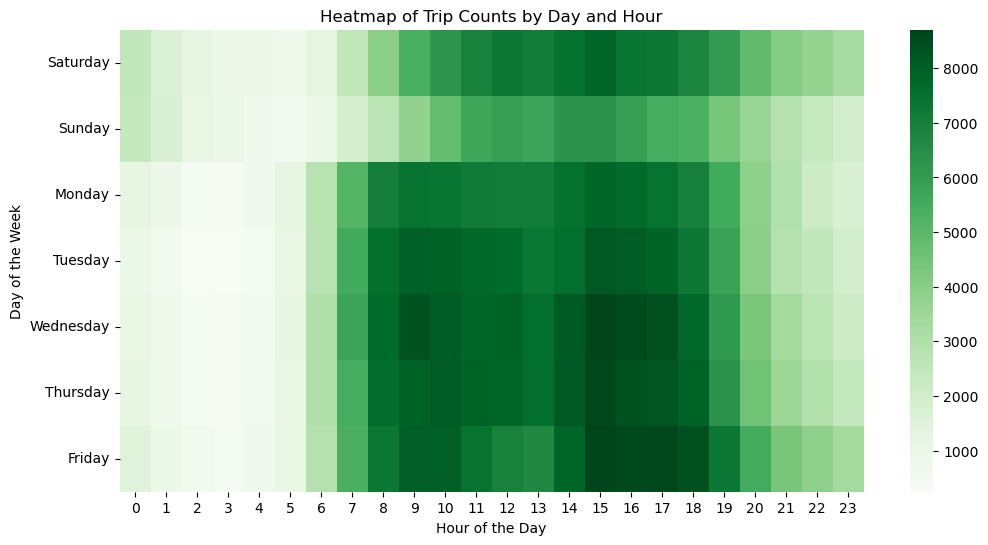

In [31]:
# Extract day of the week and hour of the day
data['day_of_week'] = data['lpep_pickup_datetime_copy'].dt.day_name()
data['hour'] = data['lpep_pickup_datetime_copy'].dt.hour

# Create a pivot table for heatmap
heatmap_data = data.pivot_table(index='day_of_week', columns='hour', values='VendorID', aggfunc='count', fill_value=0)

# Reorder the days of the week
days_order = ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
heatmap_data = heatmap_data.reindex(days_order)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='Greens', annot=False, fmt='d')
plt.title('Heatmap of Trip Counts by Day and Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.show()

Trends 
# Group by date and payment type

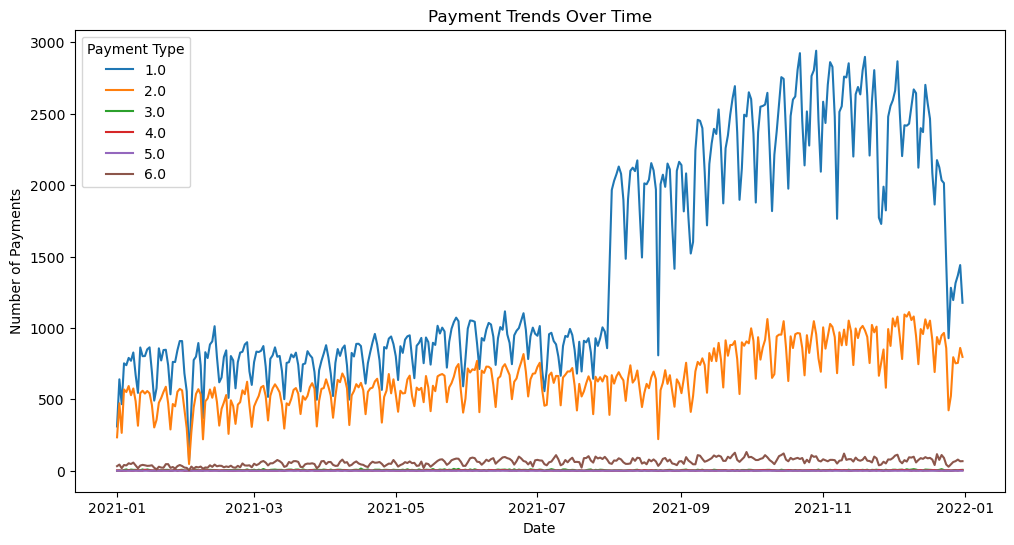

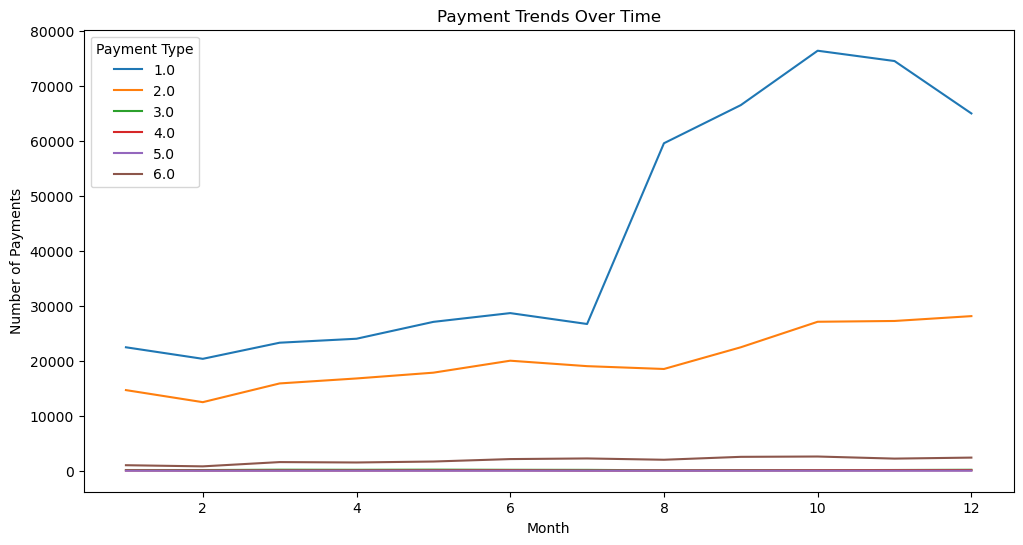

In [33]:
# Extract date and month
data['date'] = data['lpep_pickup_datetime_copy'].dt.date
data['date_month'] = data['lpep_pickup_datetime_copy'].dt.month
data['date_day'] = data['lpep_pickup_datetime_copy'].dt.day

# Group by date and payment type
payment_trends = data.groupby(['date', 'payment_type']).size().unstack(fill_value=0)
payment_trends.plot(kind='line', figsize=(12, 6))
plt.title('Payment Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Payments')
plt.legend(title='Payment Type')
plt.show()

# Group by month and payment type
payment_trends = data.groupby(['date_month', 'payment_type']).size().unstack(fill_value=0)
# Plot payment trends by month
payment_trends.plot(kind='line', figsize=(12, 6))
plt.title('Payment Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Payments')
plt.legend(title='Payment Type')
plt.show()

# Group by date and trip type

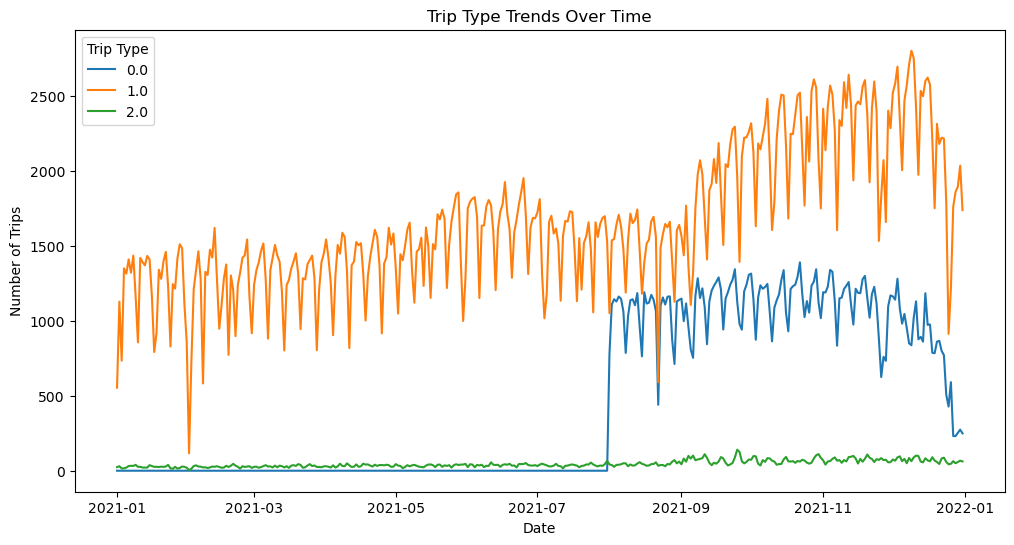

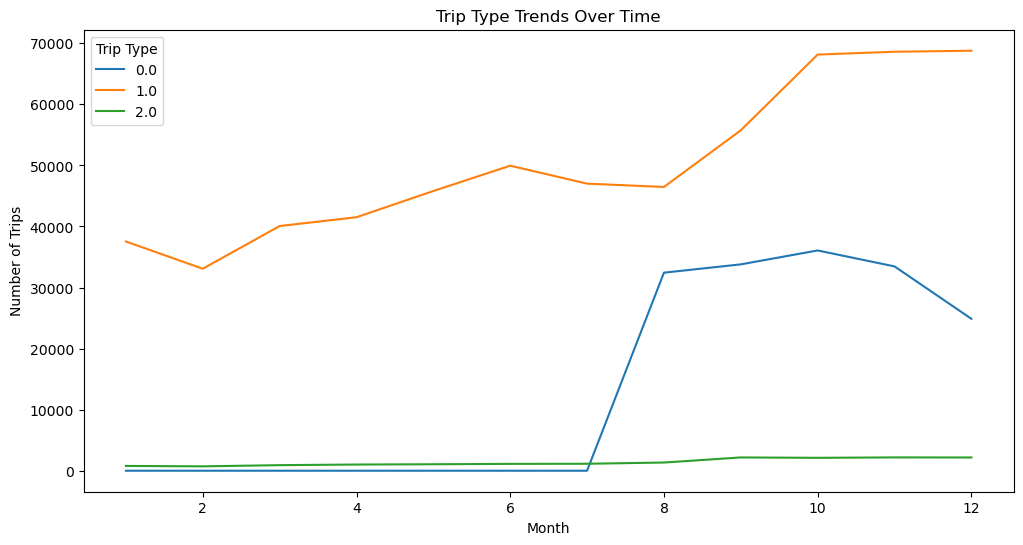

In [35]:
trip_type_trends = data.groupby(['date', 'trip_type']).size().unstack(fill_value=0)
# Plot trip type trends
trip_type_trends.plot(kind='line', figsize=(12, 6))
plt.title('Trip Type Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.legend(title='Trip Type')
plt.show()


# Group by month and trip type
trip_type_trends = data.groupby(['date_month', 'trip_type']).size().unstack(fill_value=0)
# Plot trip type trends
trip_type_trends.plot(kind='line', figsize=(12, 6))
plt.title('Trip Type Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.legend(title='Trip Type')
plt.show()

In [37]:
location_map = boroughs.set_index('LocationID')['Borough'].to_dict()
data['PU_Borough'] = data['PULocationID'].map(location_map)
data['DO_Borough'] = data['DOLocationID'].map(location_map)

# Group data by borough (Pickup)

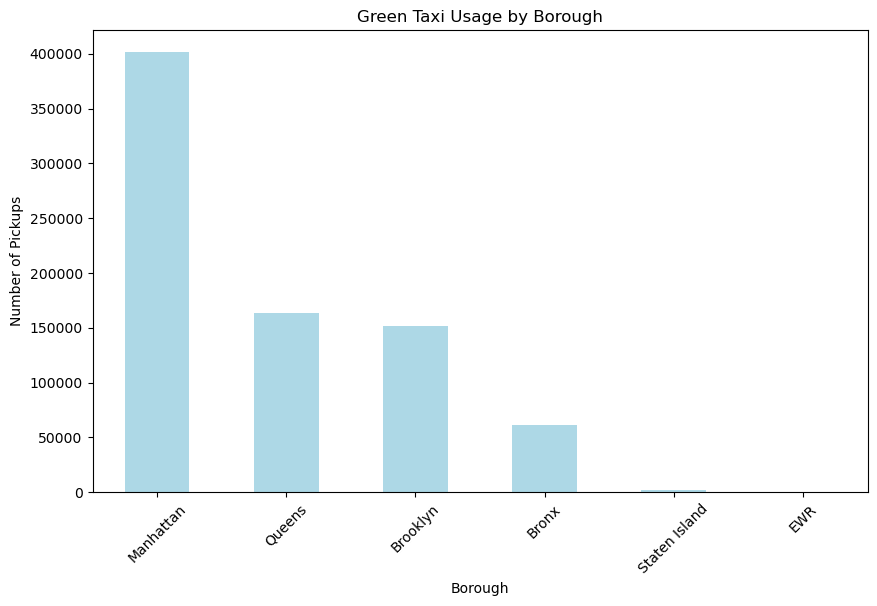

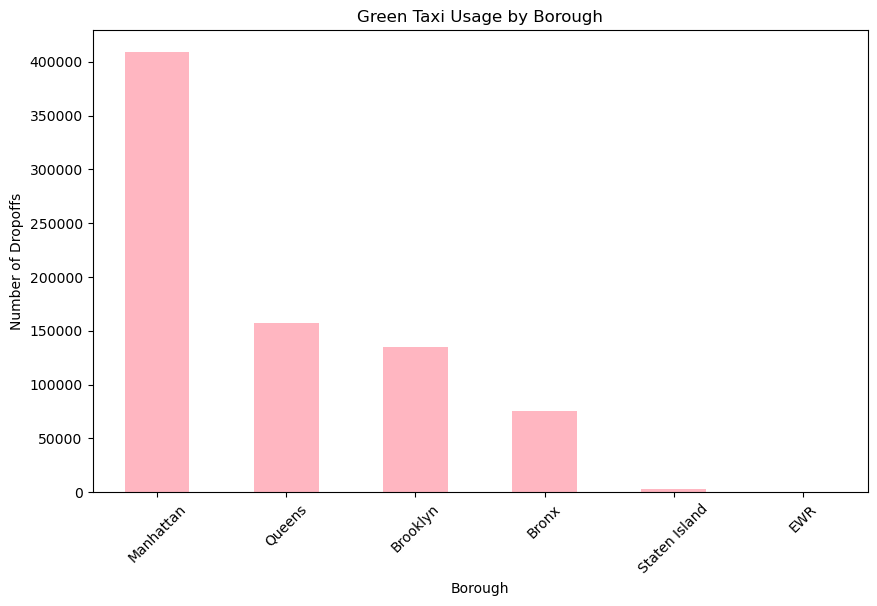

In [39]:
borough_pickup_usage = data['PU_Borough'].value_counts()

# Plot usage by borough
plt.figure(figsize=(10, 6))
borough_pickup_usage.plot(kind='bar', color='lightblue')
plt.title('Green Taxi Usage by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Pickups')
plt.xticks(rotation=45)
plt.show()


# Group data by borough (Dropoff)
borough_dropoff_usage = data['DO_Borough'].value_counts()

# Plot usage by borough
plt.figure(figsize=(10, 6))
borough_dropoff_usage.plot(kind='bar', color='lightpink')
plt.title('Green Taxi Usage by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Dropoffs')
plt.xticks(rotation=45)
plt.show()

# Group data by date and borough

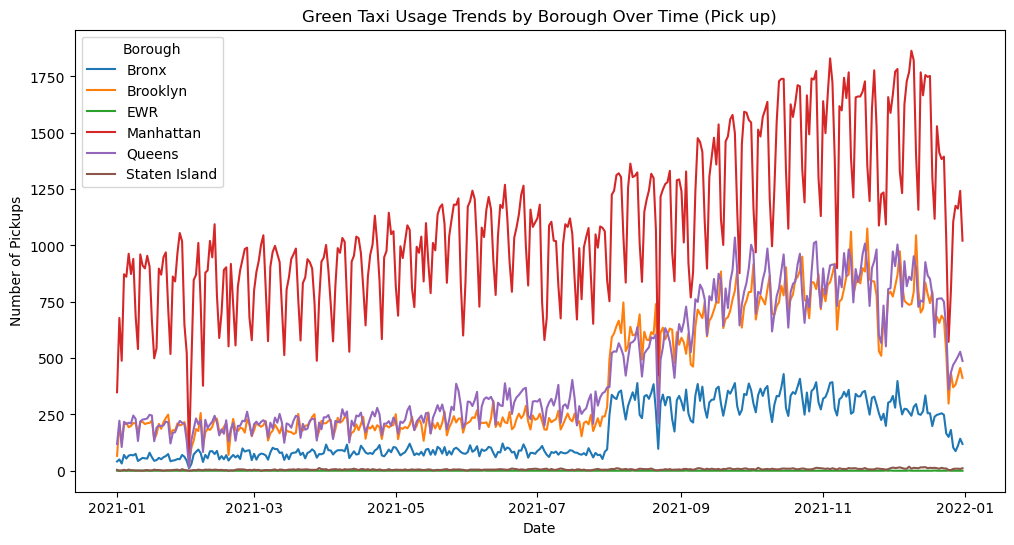

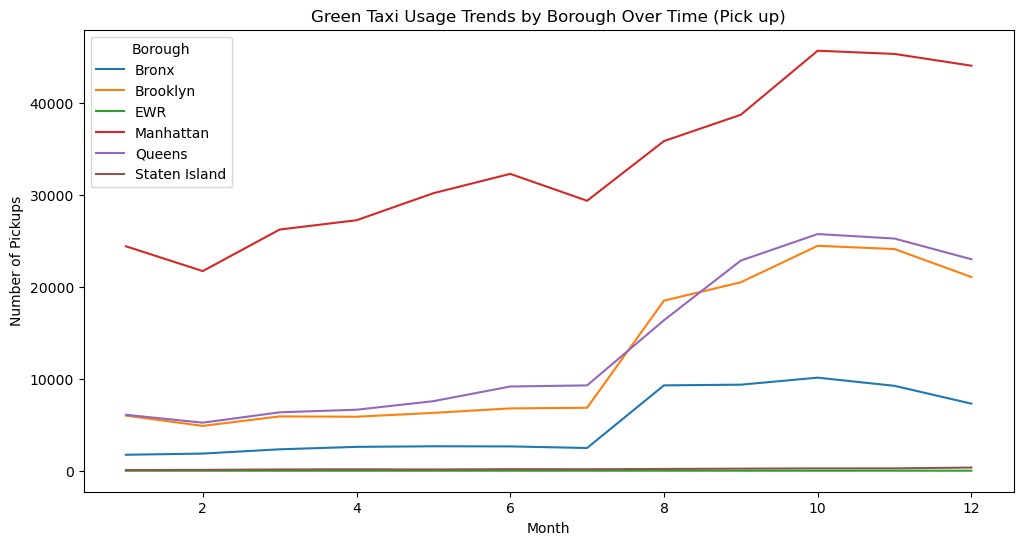

In [41]:
borough_trends_pickup = data.groupby(['date', 'PU_Borough']).size().unstack(fill_value=0)

# Plot trends
borough_trends_pickup.plot(kind='line', figsize=(12, 6))
plt.title('Green Taxi Usage Trends by Borough Over Time (Pick up)')
plt.xlabel('Date')
plt.ylabel('Number of Pickups')
plt.legend(title='Borough', loc='upper left')
plt.show()



# Group data by month and borough
borough_trends_pickup = data.groupby(['date_month', 'PU_Borough']).size().unstack(fill_value=0)

# Plot trends
borough_trends_pickup.plot(kind='line', figsize=(12, 6))
plt.title('Green Taxi Usage Trends by Borough Over Time (Pick up)')
plt.xlabel('Month')
plt.ylabel('Number of Pickups')
plt.legend(title='Borough', loc='upper left')
plt.show()

# Group data by date and borough


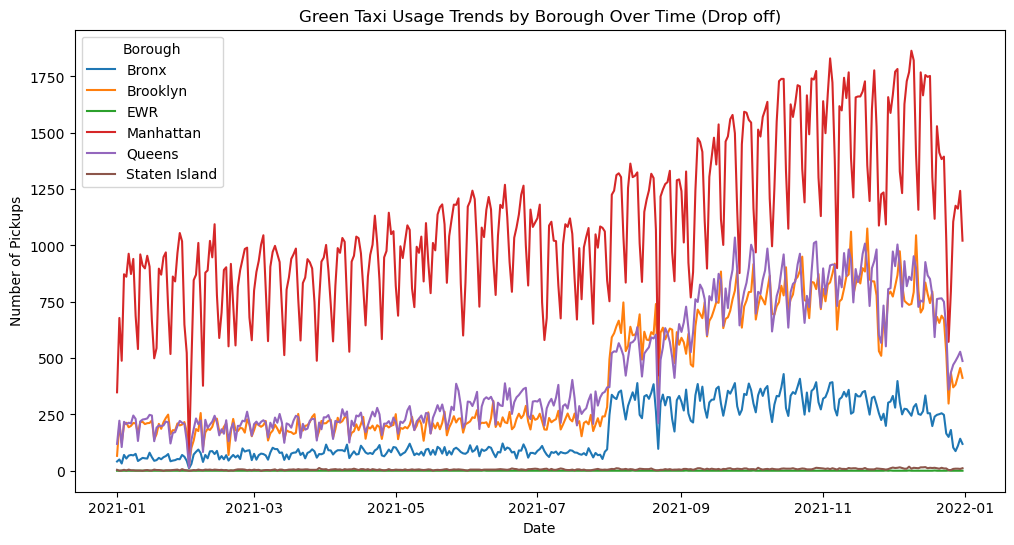

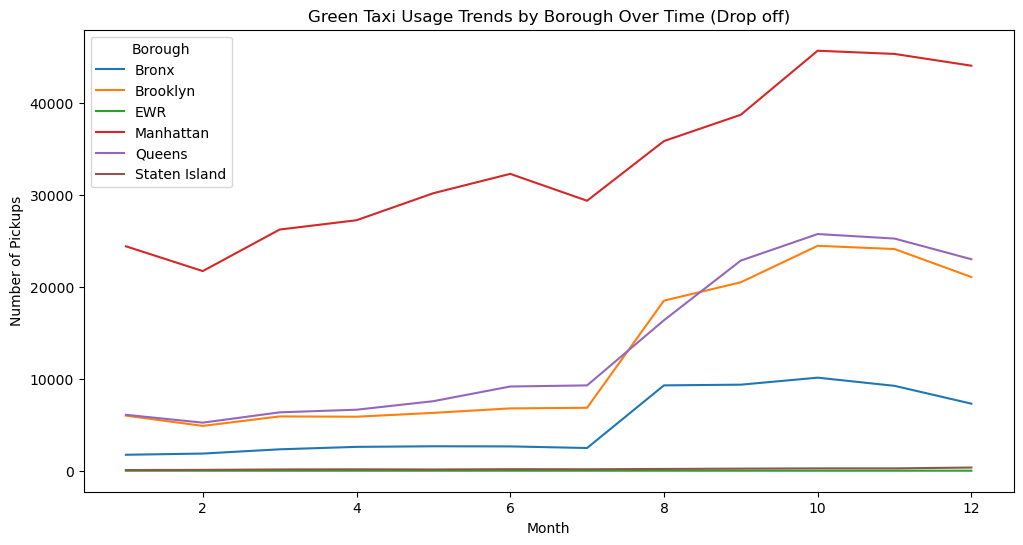

In [43]:
borough_trends_dropff = data.groupby(['date', 'PU_Borough']).size().unstack(fill_value=0)

# Plot trends
borough_trends_dropff.plot(kind='line', figsize=(12, 6))
plt.title('Green Taxi Usage Trends by Borough Over Time (Drop off)')
plt.xlabel('Date')
plt.ylabel('Number of Pickups')
plt.legend(title='Borough', loc='upper left')
plt.show()



# Group data by month and borough
borough_trends_dropff = data.groupby(['date_month', 'PU_Borough']).size().unstack(fill_value=0)

# Plot trends
borough_trends_dropff.plot(kind='line', figsize=(12, 6))
plt.title('Green Taxi Usage Trends by Borough Over Time (Drop off)')
plt.xlabel('Month')
plt.ylabel('Number of Pickups')
plt.legend(title='Borough', loc='upper left')
plt.show()

# Group by hour

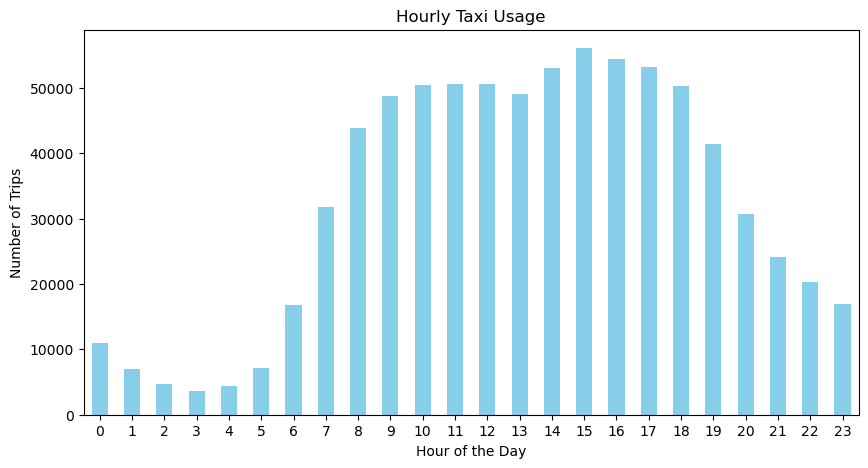

In [45]:
hourly_usage = data.groupby('hour').size()

# Plot hourly usage
plt.figure(figsize=(10, 5))
hourly_usage.plot(kind='bar', color='skyblue')
plt.title('Hourly Taxi Usage')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.xticks(rotation=0)
plt.show()


Remove the trip_distance outliers

Define a function to check normality

In [47]:
def check_normality(col):
    """Check if a column is normally distributed using the Shapiro-Wilk test."""
    sample_size = min(10000, len(col.dropna()))  # Use a sample for efficiency
    sample_data = col.dropna().sample(n=sample_size, random_state=42)
    _, p_value = shapiro(sample_data)
    return p_value > 0.05  # Normal if p-value > 0.05

# Define a function to identify and remove outliers
def identify_and_remove_outliers(data, col, method='iqr', z_threshold=3):
    """Identify and remove outliers using IQR or Z-score."""
    outliers_removed = data.copy()
    if method == 'zscore':
        # Calculate Z-scores
        outliers_removed['z_score'] = zscore(outliers_removed[col])
        outliers_removed = outliers_removed[np.abs(outliers_removed['z_score']) <= z_threshold]
        outliers_removed = outliers_removed.drop(columns=['z_score'])
    elif method == 'iqr':
        # Calculate IQR
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_removed = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return outliers_removed


Analyze the "trip_distance" column

C:\Users\asus\anaconda3\ammm\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)


'trip_distance' is not normally distributed. Using IQR method.
IQR for cleaned data: Q1 = 1.28, Q3 = 4.06, IQR = 2.7799999999999994


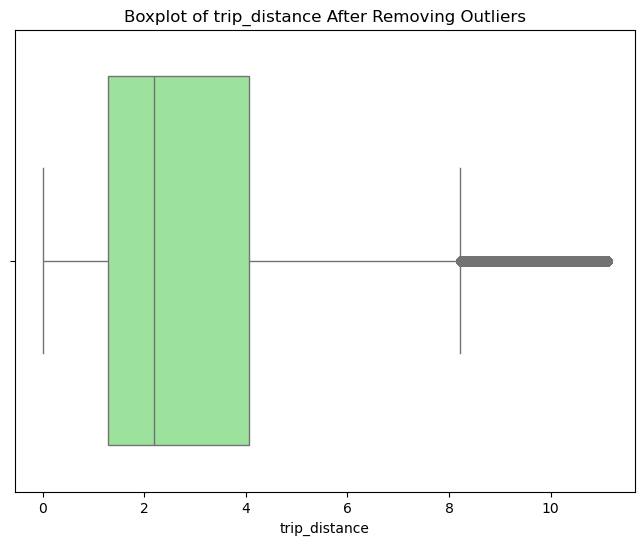

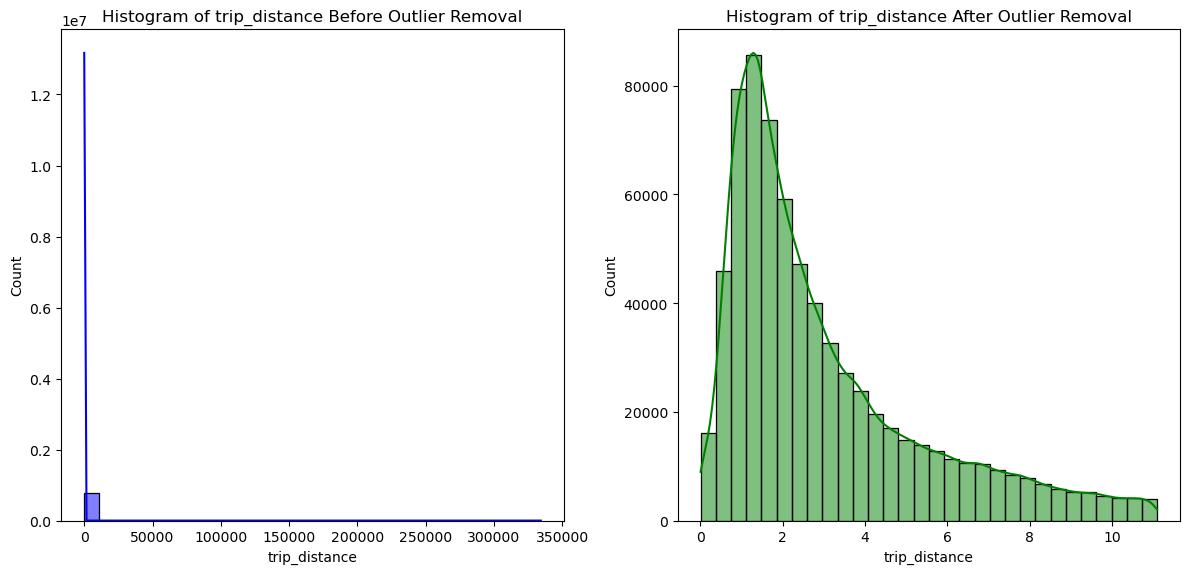

Original data size: 780150
Cleaned data size: 706811
Outliers removed: 73339 rows


In [49]:
column = 'trip_distance'

# Check if the column is normally distributed
if check_normality(data[column]):
    print(f"'{column}' is normally distributed. Using Z-score method.")
    method_to_use = 'zscore'
else:
    print(f"'{column}' is not normally distributed. Using IQR method.")
    method_to_use = 'iqr'

# Identify and remove outliers
cleaned_data = identify_and_remove_outliers(data, column, method=method_to_use)

# Calculate IQR on the cleaned data
Q1_cleaned = cleaned_data[column].quantile(0.25)
Q3_cleaned = cleaned_data[column].quantile(0.75)
IQR_cleaned = Q3_cleaned - Q1_cleaned
print(f"IQR for cleaned data: Q1 = {Q1_cleaned}, Q3 = {Q3_cleaned}, IQR = {IQR_cleaned}")

# Plot the cleaned data boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=cleaned_data[column], color='lightgreen')
plt.title(f'Boxplot of {column} After Removing Outliers')
plt.xlabel(column)
plt.show()

# Plot histograms to visualize the effect
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data[column], kde=True, color='blue', bins=30)
plt.title(f'Histogram of {column} Before Outlier Removal')

plt.subplot(1, 2, 2)
sns.histplot(cleaned_data[column], kde=True, color='green', bins=30)
plt.title(f'Histogram of {column} After Outlier Removal')
plt.tight_layout()
plt.show()

# Print stats
print(f"Original data size: {len(data)}")
print(f"Cleaned data size: {len(cleaned_data)}")
print(f"Outliers removed: {len(data) - len(cleaned_data)} rows")


Remove the total amount outliers

C:\Users\asus\anaconda3\ammm\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)


'total_amount' is not normally distributed. Using IQR method.
IQR for cleaned data: Q1 = 9.96, Q3 = 24.4, IQR = 14.439999999999998


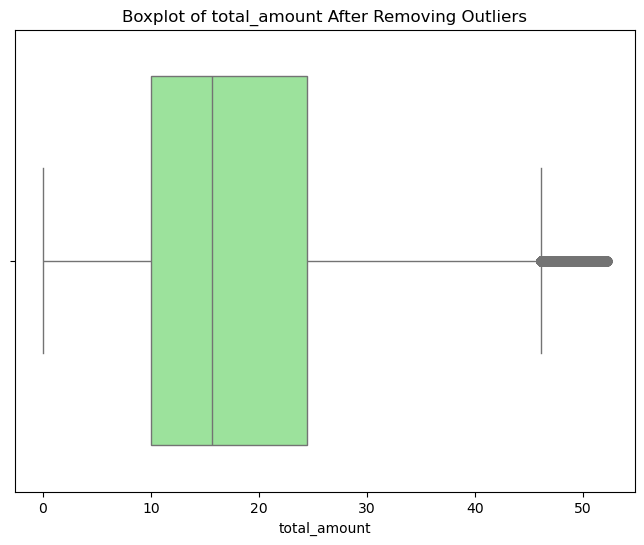

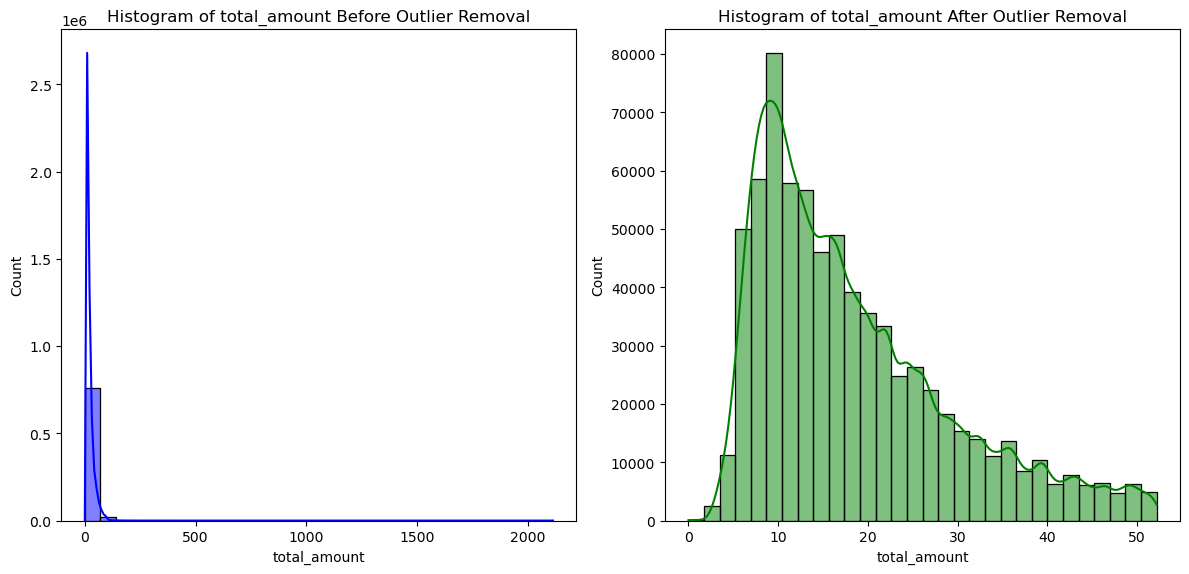

Original data size: 780150
Cleaned data size: 727231
Outliers removed: 52919 rows


In [51]:
column = 'total_amount'

# Check if the column is normally distributed
if check_normality(data[column]):
    print(f"'{column}' is normally distributed. Using Z-score method.")
    method_to_use = 'zscore'
else:
    print(f"'{column}' is not normally distributed. Using IQR method.")
    method_to_use = 'iqr'

# Identify and remove outliers
cleaned_data = identify_and_remove_outliers(data, column, method=method_to_use)

# Calculate IQR on the cleaned data
Q1_cleaned = cleaned_data[column].quantile(0.25)
Q3_cleaned = cleaned_data[column].quantile(0.75)
IQR_cleaned = Q3_cleaned - Q1_cleaned
print(f"IQR for cleaned data: Q1 = {Q1_cleaned}, Q3 = {Q3_cleaned}, IQR = {IQR_cleaned}")

# Plot the cleaned data boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=cleaned_data[column], color='lightgreen')
plt.title(f'Boxplot of {column} After Removing Outliers')
plt.xlabel(column)
plt.show()

# Plot histograms to visualize the effect
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data[column], kde=True, color='blue', bins=30)
plt.title(f'Histogram of {column} Before Outlier Removal')

plt.subplot(1, 2, 2)
sns.histplot(cleaned_data[column], kde=True, color='green', bins=30)
plt.title(f'Histogram of {column} After Outlier Removal')
plt.tight_layout()
plt.show()

# Print stats
print(f"Original data size: {len(data)}")
print(f"Cleaned data size: {len(cleaned_data)}")
print(f"Outliers removed: {len(data) - len(cleaned_data)} rows")


Remove the trip duration outliers

C:\Users\asus\anaconda3\ammm\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)


'trip_duration' is not normally distributed. Using IQR method.
IQR for cleaned data: Q1 = 475.0, Q3 = 1258.0, IQR = 783.0


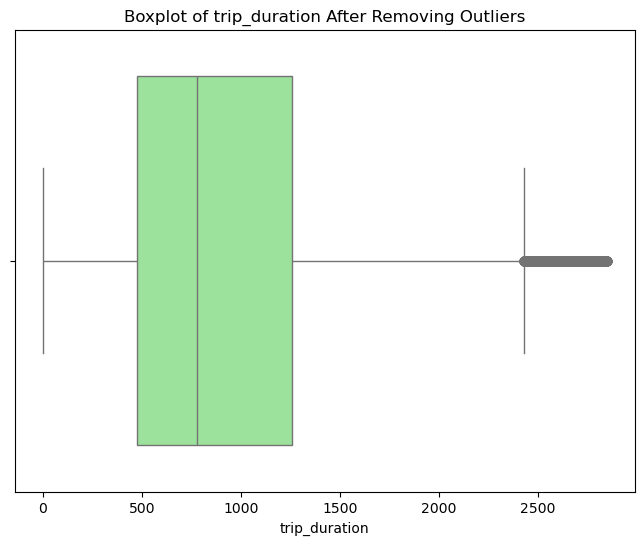

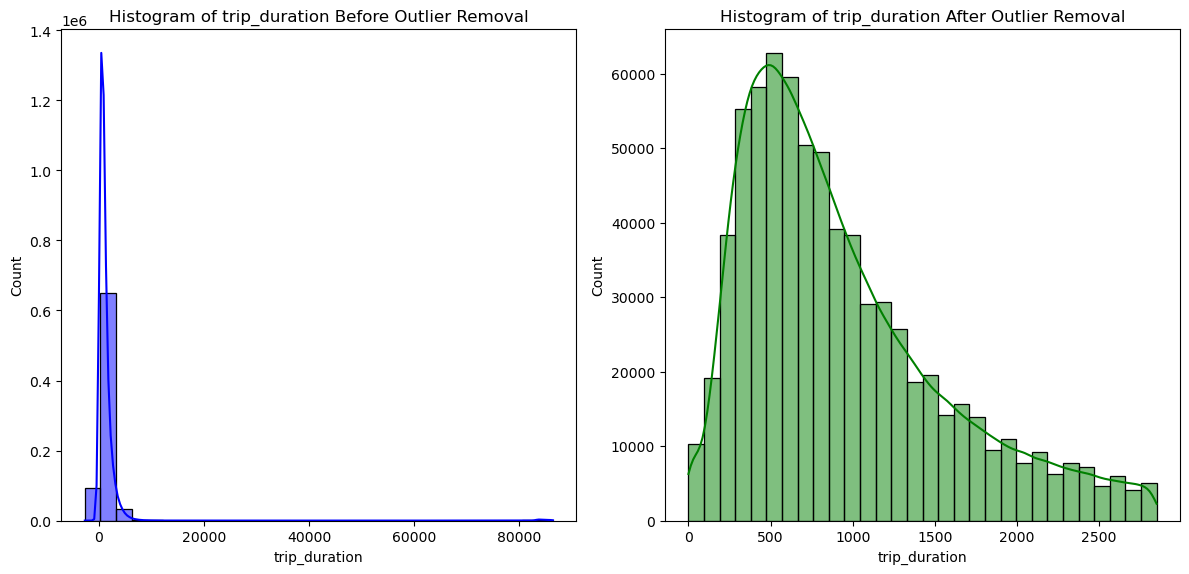

Original data size: 780150
Cleaned data size: 725229
Outliers removed: 54921 rows


In [53]:
column = 'trip_duration'

# Check if the column is normally distributed
if check_normality(data[column]):
    print(f"'{column}' is normally distributed. Using Z-score method.")
    method_to_use = 'zscore'
else:
    print(f"'{column}' is not normally distributed. Using IQR method.")
    method_to_use = 'iqr'

# Identify and remove outliers
cleaned_data = identify_and_remove_outliers(data, column, method=method_to_use)

# Calculate IQR on the cleaned data
Q1_cleaned = cleaned_data[column].quantile(0.25)
Q3_cleaned = cleaned_data[column].quantile(0.75)
IQR_cleaned = Q3_cleaned - Q1_cleaned
print(f"IQR for cleaned data: Q1 = {Q1_cleaned}, Q3 = {Q3_cleaned}, IQR = {IQR_cleaned}")

# Plot the cleaned data boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=cleaned_data[column], color='lightgreen')
plt.title(f'Boxplot of {column} After Removing Outliers')
plt.xlabel(column)
plt.show()

# Plot histograms to visualize the effect
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data[column], kde=True, color='blue', bins=30)
plt.title(f'Histogram of {column} Before Outlier Removal')

plt.subplot(1, 2, 2)
sns.histplot(cleaned_data[column], kde=True, color='green', bins=30)
plt.title(f'Histogram of {column} After Outlier Removal')
plt.tight_layout()
plt.show()

# Print stats
print(f"Original data size: {len(data)}")
print(f"Cleaned data size: {len(cleaned_data)}")
print(f"Outliers removed: {len(data) - len(cleaned_data)} rows")


Correlation matrix

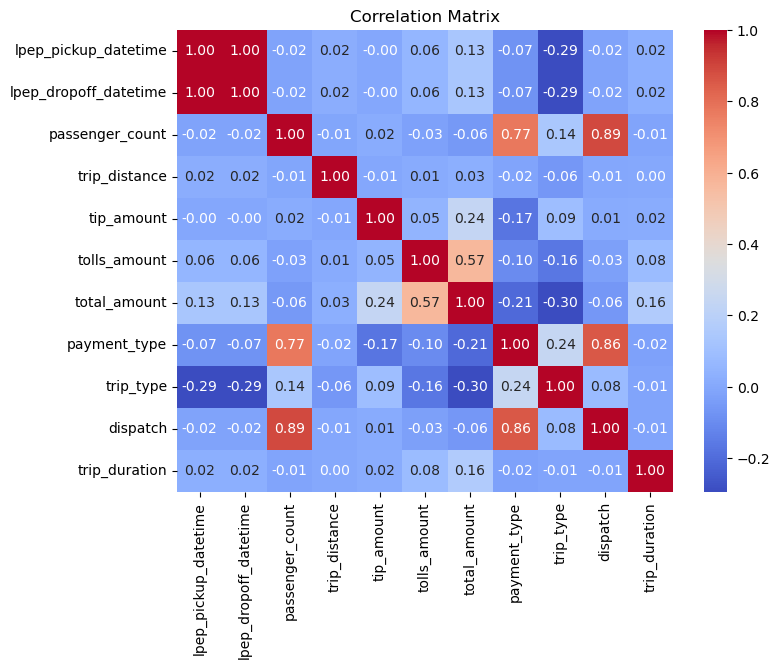

In [55]:
data.columns
data_selected = ['lpep_pickup_datetime', 'lpep_dropoff_datetime','passenger_count', 'trip_distance',
                 'tip_amount', 'tolls_amount', 'total_amount', 'payment_type',
                 'trip_type','dispatch','trip_duration']
correlation_matrix = data[data_selected].corr()
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f") 
plt.title("Correlation Matrix") 
plt.show()


Random Forest Feature Importance

<Figure size 800x600 with 0 Axes>

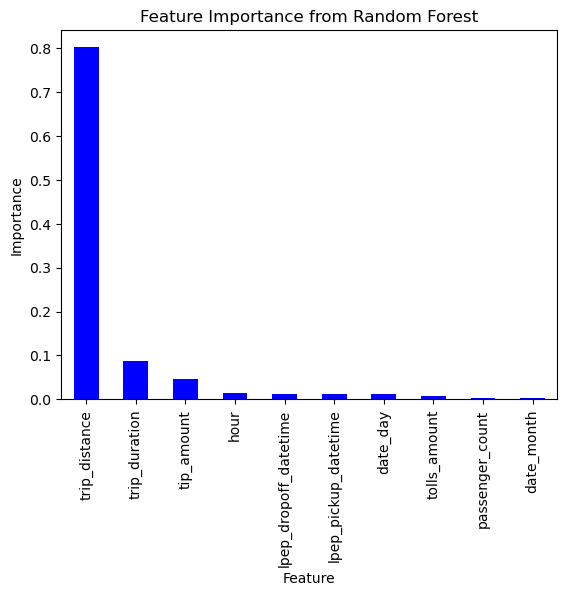

In [57]:
# Define features and target
X = data[['trip_distance', 'passenger_count', 'tip_amount', 'trip_duration',
          'tolls_amount','lpep_pickup_datetime','lpep_dropoff_datetime',
          'date_month','date_day', 'hour']]


y = data['total_amount']  # Target variable

# Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
rf_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 6))
rf_importances.plot(kind='bar', x='Feature', y='Importance', color='blue', legend=False)
plt.title('Feature Importance from Random Forest')
plt.ylabel('Importance')
plt.show()


Chi-Square Test

                 Feature     Chi2_Score   P_Value
2             tip_amount  112392.229549  0.000000
4           tolls_amount   46231.773258  0.000000
3          trip_duration    2052.115939  0.000000
9                   hour      16.923893  0.002000
6  lpep_dropoff_datetime      16.438599  0.002484
5   lpep_pickup_datetime      16.383869  0.002545
7             date_month      12.003398  0.017326
8               date_day      11.151544  0.024913
1        passenger_count       1.929263  0.748768
0          trip_distance       1.724656  0.786234


<Figure size 800x600 with 0 Axes>

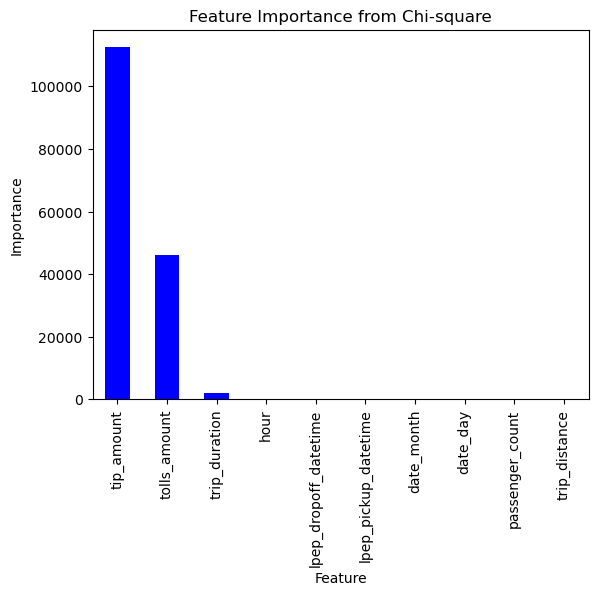

In [59]:
# Discretize numerical features into bins for chi-squared test
binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
X_binned = binner.fit_transform(X)

# Discretize target variable y
binner_target = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
y_binned = binner_target.fit_transform(y.values.reshape(-1, 1)).flatten()  # Flatten to 1D
# Perform chi-squared test
chi2_scores, p_values = chi2(X_binned, y_binned)

# Convert to DataFrame
chi2_importances = pd.DataFrame({'Feature': X.columns, 'Chi2_Score': chi2_scores, 'P_Value': p_values}).sort_values(by='Chi2_Score', ascending=False)
print(chi2_importances)
# Plot feature importance
plt.figure(figsize=(8, 6))
chi2_importances.plot(kind='bar', x='Feature', y='Chi2_Score', color='blue', legend=False)
plt.title('Feature Importance from Chi-square')
plt.ylabel('Importance')
plt.show()

Forward Elimination

<Figure size 800x600 with 0 Axes>

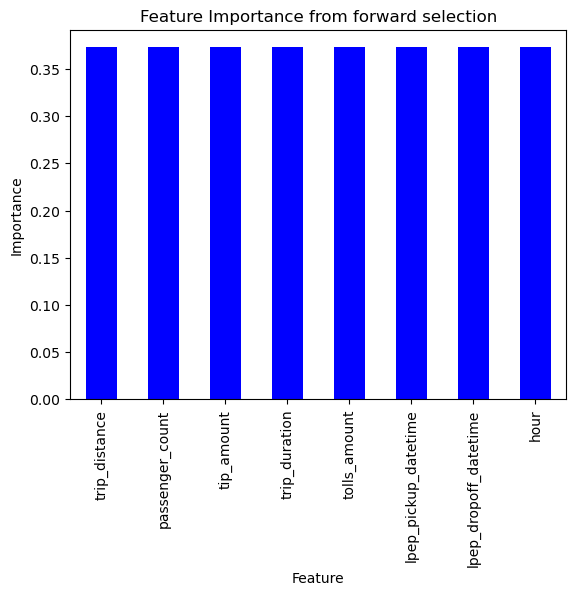

Forward Selection Importance DataFrame:
                 Feature  Forward_Score
0          trip_distance       0.372793
1        passenger_count       0.372793
2             tip_amount       0.372793
3          trip_duration       0.372793
4           tolls_amount       0.372793
5   lpep_pickup_datetime       0.372793
6  lpep_dropoff_datetime       0.372793
7                   hour       0.372793


In [61]:

# Linear regression model for forward selection
model = LinearRegression()

# Forward Selection
sfs = SFS(model, k_features='best', forward=True, floating=False, scoring='r2', cv=5)
sfs = sfs.fit(X, y)

# Selected features
forward_features = list(sfs.k_feature_names_)
forward_scores = [sfs.k_score_] * len(forward_features)  # R² score of the final model applied to all selected features

# Create Forward Selection Importance DataFrame
forward_importances = pd.DataFrame({
    'Feature': forward_features,
    'Forward_Score': forward_scores  # R² score used as an indicator of importance
})

plt.figure(figsize=(8, 6))
forward_importances.plot(kind='bar', x='Feature', y='Forward_Score', color='blue', legend=False)
plt.title('Feature Importance from forward selection')
plt.ylabel('Importance')
plt.show()

print("Forward Selection Importance DataFrame:")
print(forward_importances)

Backward Elimination

In [63]:

# Add constant for statsmodels
X_with_const = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X_with_const).fit()
print(model.summary())

# Remove features with p-value > 0.05 iteratively
while True:
    max_pval = model.pvalues.max()
    if max_pval > 0.05:
        worst_feature = model.pvalues.idxmax()
        print(f"Removing feature: {worst_feature}")
        X_with_const = X_with_const.drop(columns=[worst_feature])
        model = sm.OLS(y, X_with_const).fit()
    else:
        break

print("Final Selected Features (Backward Elimination):", X_with_const.columns.tolist())


                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                 5.639e+04
Date:                Sun, 23 Mar 2025   Prob (F-statistic):               0.00
Time:                        23:29:05   Log-Likelihood:            -3.1554e+06
No. Observations:              780150   AIC:                         6.311e+06
Df Residuals:                  780140   BIC:                         6.311e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.338e+

Comparison of the methods

In [65]:
# Compile results
comparison = pd.DataFrame({
    'Method': ['Random Forest', 'Chi-Squared', 'Forward Selection', 'Backward Elimination'],
    'Selected Features': [
        rf_importances['Feature'].tolist(),
        chi2_importances['Feature'].tolist(),
        forward_features,
        X_with_const.columns.tolist()
    ]
})

print(comparison)

# Visualize the comparison
for index, row in comparison.iterrows():
    print(f"\n{row['Method']}:\nSelected Features: {row['Selected Features']}")


                 Method                                  Selected Features
0         Random Forest  [trip_distance, trip_duration, tip_amount, hou...
1           Chi-Squared  [tip_amount, tolls_amount, trip_duration, hour...
2     Forward Selection  [trip_distance, passenger_count, tip_amount, t...
3  Backward Elimination  [const, trip_distance, passenger_count, tip_am...

Random Forest:
Selected Features: ['trip_distance', 'trip_duration', 'tip_amount', 'hour', 'lpep_dropoff_datetime', 'lpep_pickup_datetime', 'date_day', 'tolls_amount', 'passenger_count', 'date_month']

Chi-Squared:
Selected Features: ['tip_amount', 'tolls_amount', 'trip_duration', 'hour', 'lpep_dropoff_datetime', 'lpep_pickup_datetime', 'date_month', 'date_day', 'passenger_count', 'trip_distance']

Forward Selection:
Selected Features: ['trip_distance', 'passenger_count', 'tip_amount', 'trip_duration', 'tolls_amount', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'hour']

Backward Elimination:
Selected Features: [

Predicting if tip was paid or not

In [67]:

# Add the target column
data['is_tip_paid'] = data['tip_amount'].apply(lambda x: 1 if x > 0 else 0)

# Select features and target
features = ['trip_distance', 'passenger_count', 'total_amount', 'trip_duration' , "tolls_amount" ]  # Main features
data_scaled=data[features]
data_scaled=StandardScaler().fit_transform(data_scaled)
X = data_scaled
y = data['is_tip_paid']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# 1. Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)
print("Decision Tree Results")
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


# 2. Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
print("Random Forest Results")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


# 3. XGBoost Model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Results")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

# 4. K-Nearest Neighbors (KNN) Model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)
print("KNN Results")
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

# 5. Logistic Regression Model
lr_model = LogisticRegression(random_state=42, max_iter=200)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Results")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


# Compare models
def compare_models():
    print("\n\n================== Model Comparison ==================")
    print("\nDecision Tree Metrics:")
    print(classification_report(y_test, y_pred_dt))
    print("\nRandom Forest Metrics:")
    print(classification_report(y_test, y_pred_rf))
    print("\nXGBoost Metrics:")
    print(classification_report(y_test, y_pred_xgb))
    print("\nKNN Metrics:")
    print(classification_report(y_test, y_pred_knn))
    print("\nLogistic Regression Metrics:")
    print(classification_report(y_test, y_pred_lr))

compare_models()


Decision Tree Results
[[126636  10846]
 [ 11623  84940]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92    137482
           1       0.89      0.88      0.88     96563

    accuracy                           0.90    234045
   macro avg       0.90      0.90      0.90    234045
weighted avg       0.90      0.90      0.90    234045

Random Forest Results
[[130453   7029]
 [ 11052  85511]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.94    137482
           1       0.92      0.89      0.90     96563

    accuracy                           0.92    234045
   macro avg       0.92      0.92      0.92    234045
weighted avg       0.92      0.92      0.92    234045



C:\Users\asus\anaconda3\ammm\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:30:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results
[[126270  11212]
 [ 14906  81657]]
              precision    recall  f1-score   support

           0       0.89      0.92      0.91    137482
           1       0.88      0.85      0.86     96563

    accuracy                           0.89    234045
   macro avg       0.89      0.88      0.88    234045
weighted avg       0.89      0.89      0.89    234045

KNN Results
[[127023  10459]
 [ 19008  77555]]
              precision    recall  f1-score   support

           0       0.87      0.92      0.90    137482
           1       0.88      0.80      0.84     96563

    accuracy                           0.87    234045
   macro avg       0.88      0.86      0.87    234045
weighted avg       0.87      0.87      0.87    234045

Logistic Regression Results
[[134437   3045]
 [ 93764   2799]]
              precision    recall  f1-score   support

           0       0.59      0.98      0.74    137482
           1       0.48      0.03      0.05     96563

    accuracy         

Linear Regression for predicting

In [69]:
numerical_columns = ['trip_distance', 'passenger_count', 'trip_duration', 'tip_amount', 'lpep_pickup_datetime', 'lpep_dropoff_datetime','hour', 'date_day', 'tolls_amount', 'date_month']

X = data[numerical_columns]
y = data['total_amount']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Display the coefficients
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate MSE and R² score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Coefficients: [  0.31017665  -0.67502202   1.98467206   3.78632912  35.7546558
  35.75533058  -0.707574    -6.26082754   9.61436601 -69.74755427]
Intercept: 21.97080969633239
Mean Squared Error (MSE): 182.0458957734627
R² Score: 0.3984012751244058


Random Forest for predicting

In [71]:

numerical_columns = ['trip_distance', 'passenger_count', 'trip_duration', 'tip_amount', 'lpep_pickup_datetime', 'lpep_dropoff_datetime','hour', 'date_day', 'tolls_amount', 'date_month']

scaled_data = data[numerical_columns]
scaled_data = StandardScaler().fit_transform(scaled_data)

X_total = scaled_data
y = data['total_amount']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_total, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor on numerical data
rf_numerical = RandomForestRegressor(n_estimators=100, random_state=42)
rf_numerical.fit(X_train, y_train)

# Predict with the numerical model
y_pred_numerical = rf_numerical.predict(X_test)

print("Random forest Model - Mean Squared Error:", mean_squared_error(y_test, y_pred_numerical))


Random forest Model - Mean Squared Error: 28.55034551766936


Parameter optimizing using Taguchi

In [73]:

# Grid parameters for each model
param_grid_dt = {
    'max_depth': [5, 10],
    'min_samples_split': [2, 5] }

param_grid_rf_clf = {
    'n_estimators': [50, 100],
    'max_depth': [10, None],
    'min_samples_split': [2] }

param_grid_rf_reg = {
    'n_estimators': [50, 100],
    'max_depth': [10, None],
    'min_samples_split': [2] }

param_grid_xgb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 6] }

# Define training and test datasets
features = ['trip_distance', 'passenger_count', 'total_amount', 'trip_duration', 'tolls_amount']
X = data[features]
y_class = data['is_tip_paid']  # Target for classification
y_reg = data['total_amount']   # Target for regression

# Split data
X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.3, random_state=42)
_, _, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.3, random_state=42)


Function for Taguchi optimization

In [75]:
def taguchi_optimization(model_class, param_grid, X_train, y_train, X_test, y_test, is_regression=False):
    param_combinations = ParameterGrid(param_grid)
    best_params = None
    best_score = -np.inf if not is_regression else np.inf

    for params in param_combinations:
        model = model_class(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        if is_regression:
            score = -mean_squared_error(y_test, y_pred)
        else:
            score = (y_pred == y_test).mean()

        if (not is_regression and score > best_score) or (is_regression and score < best_score):
            best_score = score
            best_params = params

    return best_params, best_score


Taguchi for Decision Tree

In [77]:
print("\nRunning Taguchi for Decision Tree Classifier...")
best_params_dt, best_score_dt = taguchi_optimization(DecisionTreeClassifier, param_grid_dt, X_train, y_train_class, X_test, y_test_class)
print(f"Best Decision Tree Params: {best_params_dt}, Accuracy: {best_score_dt}")

# Taguchi for Random Forest Classifier
print("\nRunning Taguchi for Random Forest Classifier...")
best_params_rf_clf, best_score_rf_clf = taguchi_optimization(RandomForestClassifier, param_grid_rf_clf, X_train, y_train_class, X_test, y_test_class)
print(f"Best Random Forest Classifier Params: {best_params_rf_clf}, Accuracy: {best_score_rf_clf}")

# Taguchi for Random Forest Regressor
print("\nRunning Taguchi for Random Forest Regressor...")
best_params_rf_reg, best_score_rf_reg = taguchi_optimization(RandomForestRegressor, param_grid_rf_reg, X_train, y_train_reg, X_test, y_test_reg, is_regression=True)
print(f"Best Random Forest Regressor Params: {best_params_rf_reg}, MSE: {-best_score_rf_reg}")

# Taguchi for XGBoost Classifier
print("\nRunning Taguchi for XGBoost Classifier...")
best_params_xgb, best_score_xgb = taguchi_optimization(XGBClassifier, param_grid_xgb, X_train, y_train_class, X_test, y_test_class)
print(f"Best XGBoost Params: {best_params_xgb}, Accuracy: {best_score_xgb}")


Running Taguchi for Decision Tree Classifier...
Best Decision Tree Params: {'max_depth': 10, 'min_samples_split': 2}, Accuracy: 0.7979021128415476

Running Taguchi for Random Forest Classifier...
Best Random Forest Classifier Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}, Accuracy: 0.9229122604627316

Running Taguchi for Random Forest Regressor...
Best Random Forest Regressor Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}, MSE: 0.3193319822890137

Running Taguchi for XGBoost Classifier...
Best XGBoost Params: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100}, Accuracy: 0.8808348821807772
